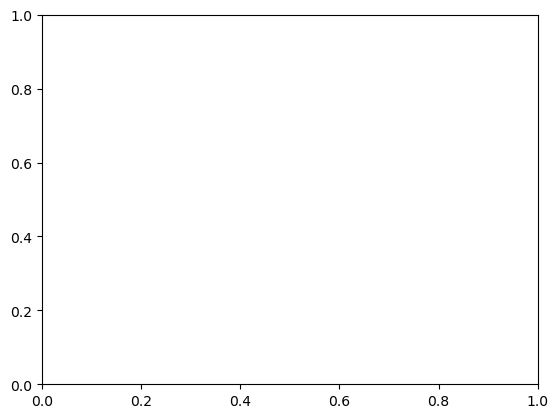

In [4]:
import gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from collections import deque
import random

# Neural Network for DQN
class DQN(nn.Module):
    def __init__(self, obs_space, action_space):
        super(DQN, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(obs_space, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, action_space)
        )

    def forward(self, x):
        return self.fc(x)

# Hyperparameters
learning_rate = 0.001
gamma = 0.99
epsilon_start = 1.0
epsilon_end = 0.01
epsilon_decay = 0.995
memory_size = 10000
batch_size = 64
target_update = 10

# Replay Memory
class ReplayMemory:
    def __init__(self, capacity):
        self.memory = deque([],maxlen=capacity)

    def push(self, *args):
        self.memory.append(tuple(args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

# Setup environment, network, optimizer, memory
env = BallSortCraneEnv()
obs_space = env.observation_space.shape[0]
action_space = env.action_space.n

policy_net = DQN(obs_space, action_space)
target_net = DQN(obs_space, action_space)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

optimizer = optim.Adam(policy_net.parameters(), lr=learning_rate)
memory = ReplayMemory(memory_size)
steps_done = 0

# Epsilon-greedy policy
def select_action(state, epsilon):
    global steps_done
    sample = random.random()
    steps_done += 1
    if sample > epsilon:
        with torch.no_grad():
            return policy_net(state).max(1)[1].view(1, 1)
    else:
        return torch.tensor([[random.randrange(action_space)]], dtype=torch.long)


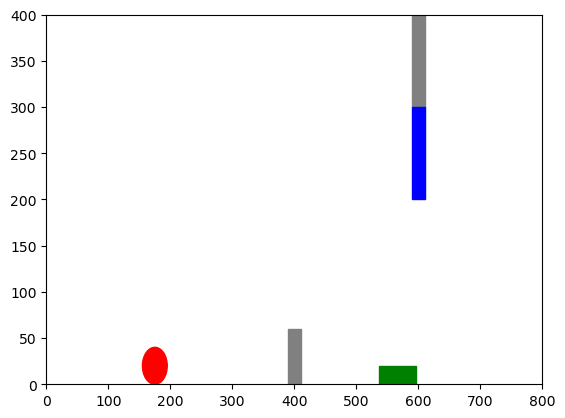

In [2]:
import gym
from gym import spaces
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib.patches as patches
# Constants
SCREEN_WIDTH = 800
SCREEN_HEIGHT = 400
BAR_WIDTH = 20
BAR_HEIGHT = 100
BALL_RADIUS = 20
BASKET_WIDTH = 60
BASKET_HEIGHT = 20
MOVEMENT_SPEED = 5
VELOCITY = 10

class BallSortCraneEnv(gym.Env):
    metadata = {'render.modes': ['human']}

    def __init__(self):
        super(BallSortCraneEnv, self).__init__()

        # Define action and observation space
        self.action_space = spaces.Discrete(5)
        self.observation_space = spaces.Box(low=0, high=max(SCREEN_WIDTH, SCREEN_HEIGHT), shape=(6,), dtype=np.float32)

        # Initialize game variables
        self.bar_x = SCREEN_WIDTH - (SCREEN_WIDTH // 4)
        self.bar_y = SCREEN_HEIGHT - (SCREEN_HEIGHT // 4)
        self.bar_height = BAR_HEIGHT
        self.extend_bar = False
        self.shrink_bar = False
        self.move_left = False
        self.move_right = False
        self.score = 0
        self.is_grabbing = False
        self.previous_distance_to_ball = float('inf')
        self.previous_distance_to_basket = float('inf')
        self.ball_x, self.ball_y, self.basket_x, self.basket_y, self.pillar_height = self.randomize_positions()
        self.figure, self.ax = plt.subplots()
        self.current_step = 0
        self.initial_bar_height = BAR_HEIGHT
        self.was_holding_ball = False
        
    def randomize_positions(self):
        ball_x = random.randint(BALL_RADIUS, SCREEN_WIDTH // 2 - BALL_RADIUS)
        basket_x = random.randint(SCREEN_WIDTH // 2 + BASKET_WIDTH // 2, SCREEN_WIDTH - BASKET_WIDTH // 2)
        max_pillar_height = SCREEN_HEIGHT // 2
        pillar_height = random.randint(50, max_pillar_height)
        ball_y = BALL_RADIUS
        basket_y = BASKET_HEIGHT // 2
        return ball_x, ball_y, basket_x, basket_y, pillar_height
    
    def is_better_position_for_grabbing(self):
        # Check if the bar is getting closer to the ball
        current_distance_to_ball = np.linalg.norm([self.ball_x - self.bar_x, self.ball_y - (self.bar_y - self.bar_height)])
        is_getting_closer = current_distance_to_ball < self.previous_distance_to_ball
        
        # Check if extending the bar is beneficial for grabbing the ball
        is_correct_extension = self.extend_bar and self.bar_y - self.bar_height > self.ball_y

        return is_getting_closer or is_correct_extension

    def is_better_position_for_releasing(self):
        # Check if the bar (with the ball) is getting closer to the basket
        current_distance_to_basket = np.linalg.norm([self.basket_x - self.bar_x, self.basket_y - (self.bar_y - self.bar_height)])
        is_getting_closer = current_distance_to_basket < self.previous_distance_to_basket

        # Check if retracting the bar is beneficial for releasing the ball
        # This can be a simple condition based on the bar's position relative to the basket.
        is_correct_retraction = self.shrink_bar and self.ball_x == self.bar_x and self.bar_y - self.bar_height < self.basket_y

        return is_getting_closer or is_correct_retraction
    
    def step(self, action):
        # Handle actions
        if action == 0:  # Move Left
            self.move_left = True
            self.move_right = False
        elif action == 1:  # Move Right
            self.move_left = False
            self.move_right = True
        elif action == 2:  # Extend Bar
            self.extend_bar = True
            self.shrink_bar = False
        elif action == 3:  # Shrink Bar
            self.extend_bar = False
            self.shrink_bar = True
        elif action == 4:  # Grab/Release
            self.is_grabbing = not self.is_grabbing

        # Update the was_holding_ball status
        if action == 4:  # Grab/Release action
            self.was_holding_ball = self.is_grabbing

        # Update game state
        self.update_game_state()

        # Calculate reward, check if game is done
        reward = self.calculate_reward()
        done = self.is_game_done()

        # Observation
        obs = np.array([self.ball_x, self.ball_y, self.bar_x, self.bar_y, self.basket_x, self.basket_y], dtype=np.float32)

        # Update the previous distances after updating the game state
        self.previous_distance_to_ball = np.linalg.norm([self.ball_x - self.bar_x, self.ball_y - (self.bar_y - self.bar_height)])
        self.previous_distance_to_basket = np.linalg.norm([self.basket_x - self.bar_x, self.basket_y - (self.bar_y - self.bar_height)])

        # Increment step count
        self.current_step += 1

        return obs, reward, done, {}



    def reset(self):
        self.current_step = 0
        self.bar_x, self.bar_y, self.bar_height = SCREEN_WIDTH - (SCREEN_WIDTH // 4), SCREEN_HEIGHT - (SCREEN_HEIGHT // 4), BAR_HEIGHT
        self.extend_bar, self.shrink_bar, self.move_left, self.move_right, self.is_grabbing = False, False, False, False, False
        self.score = 0
        self.previous_distance_to_ball = float('inf')
        self.previous_distance_to_basket = float('inf')
        self.ball_x, self.ball_y, self.basket_x, self.basket_y, self.pillar_height = self.randomize_positions()
        self.initial_bar_height = self.bar_height
        return np.array([self.ball_x, self.ball_y, self.bar_x, self.bar_y, self.basket_x, self.basket_y], dtype=np.float32)
    

    def render(self, mode='human'):
        
        self.ax.clear()
        self.ax.set_xlim(0, SCREEN_WIDTH)
        self.ax.set_ylim(0, SCREEN_HEIGHT)

        # Draw the pillar in the middle of the screen
        pillar_x = SCREEN_WIDTH // 2
        pillar = patches.Rectangle((pillar_x - 10, 0), 20, self.pillar_height, color='gray')
        self.ax.add_patch(pillar)

        # Draw the crane's arm and bar
        crane_base_x = self.bar_x
        crane_base_y = SCREEN_HEIGHT
        crane_arm_length = SCREEN_HEIGHT - self.bar_y + self.bar_height
        crane_arm = patches.Rectangle((crane_base_x - BAR_WIDTH/2, self.bar_y), BAR_WIDTH, crane_arm_length, color='gray')
        self.ax.add_patch(crane_arm)
        bar = patches.Rectangle((self.bar_x - BAR_WIDTH/2, self.bar_y - self.bar_height), BAR_WIDTH, self.bar_height, color='blue')
        self.ax.add_patch(bar)

        # Draw the ball
        ball = patches.Circle((self.ball_x, self.ball_y), BALL_RADIUS, color='red')
        self.ax.add_patch(ball)

        # Draw the basket
        basket = patches.Rectangle((self.basket_x - BASKET_WIDTH/2, self.basket_y - BASKET_HEIGHT/2), BASKET_WIDTH, BASKET_HEIGHT, color='green')
        self.ax.add_patch(basket)
        
        if mode == 'rgb_array':
            # Convert the plot to an RGB array
            self.figure.canvas.draw()
            width, height = self.figure.get_size_inches() * self.figure.get_dpi()
            image = np.frombuffer(self.figure.canvas.tostring_rgb(), dtype='uint8')
            image = image.reshape(int(height), int(width), 3)
            return image
        elif mode == 'human':
            # [Existing code for human rendering]
            plt.draw()
            plt.pause(0.01)

    def close(self):
        plt.close(self.figure)

    def update_game_state(self):
        # Update bar position
        if self.move_left:
            self.bar_x = max(self.bar_x - MOVEMENT_SPEED, BAR_WIDTH / 2)
        if self.move_right:
            self.bar_x = min(self.bar_x + MOVEMENT_SPEED, SCREEN_WIDTH - BAR_WIDTH / 2)

        # Update bar height
        if self.extend_bar and self.bar_height < SCREEN_HEIGHT - self.bar_y:
            self.bar_height += 10
        if self.shrink_bar and self.bar_height > 10:
            self.bar_height -= 10

        # Handle ball grabbing logic
        if self.is_grabbing:
            # Check if the bar is above the ball
            if self.bar_x - BAR_WIDTH / 2 < self.ball_x < self.bar_x + BAR_WIDTH / 2 and \
               self.ball_y < self.bar_y - self.bar_height + BALL_RADIUS:
                self.ball_x = self.bar_x
                self.ball_y = self.bar_y - self.bar_height + BALL_RADIUS
        else:
            # Ball falls due to gravity
            if self.ball_y > BALL_RADIUS:
                self.ball_y -= VELOCITY
            else:
                self.ball_y = BALL_RADIUS  # Ensure ball doesn't go below the ground
                
    def is_directly_above_basket(self):
            # Define a threshold for being considered 'directly above'
            threshold = 10  # Adjust this value as needed

            # Check if the bar's horizontal position is close enough to the basket's position
            return abs(self.bar_x - self.basket_x) < threshold and self.bar_y - self.bar_height < self.basket_y + BASKET_HEIGHT / 2        
        
    def is_ball_in_basket(self):
        # Check if the ball is within the horizontal boundaries of the basket
        ball_in_basket_horizontally = (self.ball_x + BALL_RADIUS > self.basket_x - BASKET_WIDTH / 2) and \
                                      (self.ball_x - BALL_RADIUS < self.basket_x + BASKET_WIDTH / 2)

        # Check if the ball is within the vertical boundaries of the basket
        ball_in_basket_vertically = (self.ball_y - BALL_RADIUS < self.basket_y + BASKET_HEIGHT / 2) and \
                                    (self.ball_y + BALL_RADIUS > self.basket_y - BASKET_HEIGHT / 2)

        # The ball is in the basket if it's within both horizontal and vertical boundaries
        return ball_in_basket_horizontally and ball_in_basket_vertically
    def is_directly_above_ball(self):
            # Define a threshold for being considered 'directly above'
            threshold = 10  # Adjust this value as needed

            # Check if the bar's horizontal position is close enough to the ball's position
            return abs(self.bar_x - self.ball_x) < threshold and self.ball_y < self.bar_y - self.bar_height
        
    def calculate_reward(self):
        # Initialize reward
        action_penalty = -0.05
        reward = 0
        reward += action_penalty
        # Calculate the distance to the ball and to the basket
        distance_to_ball = np.linalg.norm([self.ball_x - self.bar_x, self.ball_y - (self.bar_y - self.bar_height)])
        distance_to_basket = np.linalg.norm([self.basket_x - self.bar_x, self.basket_y - (self.bar_y - self.bar_height)])

        # Reward/Penalty for moving closer/away from the ball
        if distance_to_ball < self.previous_distance_to_ball:
            reward += 1
        else:
            reward -= 0.5

        # Additional reward for successfully grabbing the ball
        #if self.is_grabbing and self.is_directly_above_ball():
        #    reward += 5

        # Reward for successfully dropping the ball in the basket
        if self.is_ball_in_basket() and not self.is_grabbing:
            reward += 1000

        # Reward for dropping the ball closer to the basket
        if not self.is_grabbing and self.was_holding_ball:
            # Calculate the distance from the basket
            distance_from_basket = np.linalg.norm([self.basket_x - self.ball_x, self.basket_y - self.ball_y])

            # Apply a reward based on the distance - closer gets more reward
            reward += max(0, 10 - distance_from_basket)  # Adjust as needed

            # Reset was_holding_ball after the ball is released
            self.was_holding_ball = False
        # Update the was_holding_ball status
        if not self.is_grabbing:
            self.was_holding_ball = False
        
        # Update the previous distances for the next step
        self.previous_distance_to_ball = distance_to_ball
        self.previous_distance_to_basket = distance_to_basket
        
        # Penalty for unnecessary extension/retraction
        #if self.extend_bar or self.shrink_bar:
            # Check if the crane is directly above the ball or directly above the basket while holding the ball
        #    directly_above_ball = self.is_directly_above_ball()
        #    directly_above_basket_while_holding = self.is_grabbing and self.is_directly_above_basket()

            # Apply penalty if not directly above the ball and not directly above basket while holding the ball
         #   if not directly_above_ball and not directly_above_basket_while_holding:
         #       reward -= 0.2  # Define this penalty value as needed

        return reward


    def is_game_done(self):
        max_score = 50
        max_steps = 1000
        ball_in_basket = self.is_ball_in_basket()
        return self.score >= max_score or self.current_step >= max_steps or ball_in_basket


# Create and test your environment
env = BallSortCraneEnv()
env.reset()
env.render()

In [ ]:
import imageio
import base64
import IPython
import gym
import numpy as np
import torch

# Assuming BallSortCraneEnv and DQN classes are already defined

# Function to embed the video in the notebook
def embed_mp4(filename):
    """Embeds an mp4 file in the notebook."""
    video = open(filename, 'rb').read()
    b64 = base64.b64encode(video)
    tag = f'''
    <video width="640" height="480" controls>
        <source src="data:video/mp4;base64,{b64.decode()}" type="video/mp4">
        Your browser does not support the video tag.
    </video>'''
    return IPython.display.HTML(tag)

# Initialize the environment and agent
env = BallSortCraneEnv()
state_size = env.observation_space.shape[0]
action_size = env.action_space.n

# Initialize the policy network (assuming it's already trained)
policy_net = DQN(state_size, action_size)

# Load the trained model
model_path = 'dqn_model.pth'  # Adjust the path to your trained model file
policy_net.load_state_dict(torch.load(model_path))
policy_net.eval()  # Set the model to evaluation mode

# Function to select an action using the trained model
def select_action(state):
    with torch.no_grad():
        return policy_net(torch.tensor([state], dtype=torch.float32)).max(1)[1].view(1, 1)

# Define the number of episodes and video filename
num_episodes = 3
video_filename = 'ball_sort_crane_gameplay.mp4'

# Create a video writer
with imageio.get_writer(video_filename, fps=60) as video:
    for _ in range(num_episodes):
        state = env.reset()
        video.append_data(env.render(mode='rgb_array'))
        done = False
        while not done:
            action = select_action(state).item()
            next_state, reward, done, _ = env.step(action)
            state = next_state
            video.append_data(env.render(mode='rgb_array'))

# Embed the video in the notebook
embed_mp4(video_filename)
